参考文档教程：
https://langchain-ai.github.io/langgraph/tutorials/get-started/2-add-tools/



In [ ]:
# https://python.langchain.com/docs/integrations/tools/tavily_search/

# 获取密钥的地址： https://app.tavily.com/sign-in




import os
TAVILY_API_KEY="tvly-dev-123"
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY


In [11]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=5)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")


{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': "Introduction to LangGraph: A Beginner's Guide - Medium",
   'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
   'content': 'Stateful Graph: LangGraph revolves around the concept of a stateful graph, where each node in the graph represents a step in your computation, and the graph maintains a state that is passed around and updated as the computation progresses. LangGraph supports conditional edges, allowing you to dynamically determine the next node to execute based on the current state of the graph. We define nodes for classifying the input, handling greetings, and handling search queries. def classify_input_node(state): LangGraph is a versatile tool for building complex, stateful applications with LLMs. By understanding its core concepts and working through simple examples, beginners can start to leverage its powe

In [12]:
import os
from langchain.chat_models import init_chat_model

API_KEY = "sk-123"

BASE_URL = "https://api.deepseek.com"

os.environ["OPENAI_API_KEY"] = API_KEY
os.environ["OPENAI_API_BASE"] = BASE_URL


llm = init_chat_model("openai:deepseek-chat")

In [13]:
#我们现在可以将它合并到 ：StateGraph

from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# Modification: tell the LLM which tools it can call
# highlight-next-line
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [14]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

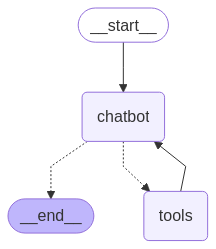

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [16]:
#8. 向机器人提问
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        print("User: " + user_input)
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: langgraph是什么
Assistant: 
Assistant: {"query": "langgraph是什么", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.cnblogs.com/smartloli/p/18276355", "title": "LangGraph实战- 哥不是小萝莉- 博客园", "content": "2.内容 LangGraph是一个功能强大的库，用于构建基于大型语言模型（LLM）的有状态、多参与者应用程序。 它旨在创建代理和多代理工作流，以实现复杂的任务和交", "score": 0.9202254, "raw_content": null}, {"url": "https://blog.csdn.net/musicml/article/details/136441895", "title": "一文搞懂LangChain 新利器：LangGraph 原创 - CSDN博客", "content": "LangGraph 是一个有用于构建有状态和多角色的 Agents 应用，它并不是一个独立于 Langchain 的新框架，而是基于 Langchain 之上构建的一个扩展库，可以与 Langchain 现有的链（Chains）、LangChain Expression Language（LCEL）等无缝协作。LangGraph 能够协调多个 Chain、Agent、Tool 等共同协作来完成输入任务，支持 LLM 调用“循环”和 Agent 过程的更精细化控制。\nLangGraph 的实现方式是把之前基于 AgentExecutor 的黑盒调用过程，用一种新的形式来构建：状态图（StateGraph）。把基于 LLM 的任务（比如：RAG、代码生成等）细节用 Graph 进行精确的定义（定义图的节点与边），最后基于这个图来编译生成应用。在任务运行过程中，维持一个中央状态对象(state)，会根据节点的跳转不断更新，状态包含的属性可自行定义。\n我们一起剖析下官方 RAG 应用的 Graph 案例，如下图所示，从而更好理解 LangGraph。 [...] Lan_g_Graph 